# Match Effects

The purpose of this notebook is to examine the various factors computed from historical match data, and determine the ability these factors have to help predict the outcomes of future matches. We include matches played within the same season as each predicted match, as well as end-of-season statistics computed from the previous season. We may also include environmental features for the predicted match, including temporal factors (e.g. day of week, time of day), physical factors (e.g. match ground, distance travelled to match), atmospheric factors (e.g. prevailing wind directions, intensity of wind, rain or shine), and other factors (e.g. home or away).

## Load the data

In [1]:
import sys
import os

sys.path.append(os.path.join("..", "python"))

In [71]:
import match_tools
import stats_tools
from stats_tools import logit, logistic
from core_dist import no_intercept, add_intercept
from bernoulli_dist import BernoulliDistribution

In [3]:
import numpy as np
import pandas as pd

In [4]:
import matplotlib.pyplot as plt

In [70]:
from sklearn.linear_model import LinearRegression

### Load match results

In [5]:
df_matches = pd.read_csv(os.path.join("..", "data", "matches.csv"))

In [6]:
match_tools.add_timestamp(df_matches)

In [7]:
match_tools.add_hash(df_matches)

In [8]:
df_matches

,season,round,datetime,venue,for_team,for_is_home,for_goals1,for_behinds1,for_goals2,for_behinds2,...,against_behinds4,against_total_score,against_match_points,against_is_win,against_is_draw,against_is_loss,edge_type,timestamp,for_hash,against_hash
0,1990,R1,Sat 31-Mar-1990 2:10 PM,M.C.G.,Melbourne,False,6,2,4,1,...,4,89,0,False,False,True,defeated,1990-03-31 14:10:00,-1091802772995086567,320583232929465573
1,1990,R1,Sat 31-Mar-1990 2:10 PM,Waverley Park,Geelong,True,5,3,2,3,...,6,192,4,True,False,False,lost-to,1990-03-31 14:10:00,7851315364042659657,-3602718394855019970
2,1990,R1,Sat 31-Mar-1990 2:10 PM,Princes Park,Carlton,True,6,5,4,4,...,5,104,4,True,False,False,lost-to,1990-03-31 14:10:00,-8654254387718271654,-3655016407353297127
3,1990,R1,Sat 31-Mar-1990 2:10 PM,Windy Hill,Essendon,True,7,4,6,7,...,4,60,0,False,False,True,defeated,1990-03-31 14:10:00,763794529889676985,4360381151905338274
4,1990,R1,Sat 31-Mar-1990 7:40 PM,Carrara,Brisbane Bears,True,4,3,3,2,...,2,74,0,False,False,True,defeated,1990-03-31 19:40:00,3326882177787585227,2915980218005407078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6165,2022,R18,Sat 16-Jul-2022 5:30 PM,Perth Stadium,Fremantle,True,3,3,3,2,...,4,82,4,True,False,False,lost-to,2022-07-16 17:30:00,4463889549496467621,-8328083744867390542
6166,2022,R18,Sat 16-Jul-2022 7:25 PM,M.C.G.,Carlton,True,4,1,1,0,...,5,85,4,True,False,False,lost-to,2022-07-16 19:25:00,-6711135500448446972,-6556888912899297277
6167,2022,R18,Sun 17-Jul-2022 1:10 PM,M.C.G.,Hawthorn,True,2,3,7,0,...,0,77,0,False,False,True,defeated,2022-07-17 13:10:00,-6449580398855473003,5598528457670248926
6168,2022,R18,Sun 17-Jul-2022 2:50 PM,Traeger Park,Melbourne,True,0,4,5,3,...,3,69,0,False,False,True,defeated,2022-07-17 14:50:00,-2087023396824766421,8665788491490141410


### Load end-of-season statistics

In [9]:
df_seasonal = pd.read_csv(os.path.join("..", "data", "end_season_features.csv"))

In [10]:
df_seasonal

,season,team,teams,games,wins,draws,losses,wins_ratio,points_for,points_against,...,behinds_against,accuracy_against,goals_ratio,behinds_ratio,rank,rank_score,wins_prestige,adj_wins_prestige,points_prestige,adj_points_prestige
0,1990,Brisbane Bears,14,22,4,0,18,0.181818,1733,2426,...,338,0.507289,0.415126,0.426146,14,0.000000,0.003774,0.046936,0.049030,0.401289
1,1990,Carlton,14,22,11,0,11,0.500000,2277,2187,...,315,0.497608,0.517774,0.458763,8,0.461538,0.055508,0.433112,0.073333,0.507091
2,1990,Collingwood,14,26,19,1,6,0.750000,2798,2077,...,313,0.484349,0.578797,0.544396,1,1.000000,0.232418,0.797419,0.096696,0.581871
3,1990,Essendon,14,25,18,0,7,0.720000,2742,2079,...,297,0.500000,0.571429,0.552036,2,0.923077,0.172837,0.730920,0.096170,0.580403
4,1990,Fitzroy,14,22,7,0,15,0.318182,1874,2389,...,319,0.519578,0.433498,0.476190,12,0.153846,0.019412,0.204675,0.057674,0.443097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,2022,Richmond,18,17,9,0,8,0.529412,1631,1418,...,200,0.503722,0.540724,0.496222,8,0.588235,0.035989,0.388251,0.058767,0.514896
541,2022,St Kilda,18,17,9,0,8,0.529412,1333,1311,...,195,0.488189,0.509235,0.472973,10,0.470588,0.052259,0.483842,0.057077,0.507158
542,2022,Sydney,18,17,11,0,6,0.647059,1546,1280,...,176,0.511111,0.549020,0.534392,6,0.705882,0.103283,0.661940,0.065234,0.542620
543,2022,West Coast,18,17,2,0,15,0.117647,1084,1888,...,202,0.581781,0.361364,0.391566,17,0.058824,0.008256,0.123970,0.032211,0.361357


In [11]:
all_seasons = sorted(set(df_seasonal.season))

# Exclude the last season, as it is currently incomplete
removed_season = all_seasons[-1]
all_seasons = all_seasons[:-1]
df_seasonal = df_seasonal.loc[df_seasonal.season < removed_season].copy()

### Load within-season statistics

In [12]:
df_within = pd.read_csv(os.path.join("..", "data", "within_season_features.csv"))

In [13]:
match_tools.add_timestamp(df_within)

In [14]:
match_tools.add_hash(df_within)

In [15]:
df_within

,datetime,round,venue,season,team,teams,games,wins,draws,losses,...,goals_ratio,behinds_ratio,rank,rank_score,wins_prestige,adj_wins_prestige,points_prestige,adj_points_prestige,timestamp,hash
0,Fri 06-Apr-1990 7:40 PM,R2,M.C.G.,1990,North Melbourne,14,1,0,0,1,...,0.352941,0.629630,9,0.384615,0.000000,0.000000,0.000000,0.000000,1990-04-06 19:40:00,1862631452339231754
1,Fri 06-Apr-1990 7:40 PM,R2,M.C.G.,1990,Richmond,14,1,0,0,1,...,0.344828,0.424242,11,0.230769,0.000000,0.000000,0.357488,0.878539,1990-04-06 19:40:00,-4994366463861596387
8,Sat 07-Apr-1990 2:10 PM,R2,Waverley Park,1990,Carlton,14,1,0,0,1,...,0.482759,0.517241,9,0.384615,0.000000,0.000000,0.000000,0.000000,1990-04-07 14:10:00,-5188764782368933320
7,Sat 07-Apr-1990 2:10 PM,R2,Princes Park,1990,Fitzroy,14,1,0,0,1,...,0.285714,0.363636,12,0.153846,0.000000,0.000000,0.000000,0.000000,1990-04-07 14:10:00,-3557044473806227243
6,Sat 07-Apr-1990 2:10 PM,R2,Princes Park,1990,Brisbane Bears,14,1,1,0,0,...,0.655172,0.575758,4,0.769231,1.000000,1.000000,0.166808,0.722426,1990-04-07 14:10:00,-3451549362242426712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11790,Sun 17-Jul-2022 1:10 PM,R18,M.C.G.,2022,West Coast,18,16,2,0,14,...,0.355932,0.396825,17,0.058824,0.008529,0.127583,0.031821,0.358452,2022-07-17 13:10:00,5598528457670248926
11791,Sun 17-Jul-2022 2:50 PM,R18,Traeger Park,2022,Melbourne,18,16,12,0,4,...,0.573913,0.558074,2,0.941176,0.097317,0.646986,0.070612,0.563625,2022-07-17 14:50:00,-2087023396824766421
11792,Sun 17-Jul-2022 2:50 PM,R18,Traeger Park,2022,Port Adelaide,18,16,8,0,8,...,0.523810,0.502841,12,0.352941,0.036242,0.389980,0.057722,0.510135,2022-07-17 14:50:00,8665788491490141410
11793,Sun 17-Jul-2022 4:40 PM,R18,Docklands,2022,Essendon,18,16,5,0,11,...,0.445844,0.490251,16,0.117647,0.018756,0.245248,0.046731,0.454557,2022-07-17 16:40:00,-187035954075866286


In [16]:
print(list(df_within.columns))

['datetime', 'round', 'venue', 'season', 'team', 'teams', 'games', 'wins', 'draws', 'losses', 'wins_ratio', 'points_for', 'points_against', 'points_ratio', 'goals_for', 'behinds_for', 'accuracy_for', 'goals_against', 'behinds_against', 'accuracy_against', 'goals_ratio', 'behinds_ratio', 'rank', 'rank_score', 'wins_prestige', 'adj_wins_prestige', 'points_prestige', 'adj_points_prestige', 'timestamp', 'hash']


### Load seasonal sequences

In [17]:
df_sequences = pd.read_csv(os.path.join("..", "data", "season_sequences.csv"))

In [18]:
df_sequences

,season,team,sequence_length,sequence
0,1990,Brisbane Bears,22,WLLLLLWLLLLLLLWLLLWLLL
1,1990,Carlton,22,LLWLLWWWWLLWWWLWLWLWLL
2,1990,Collingwood,22,LWWWWLLWWWWWWWWWLWLLWW
3,1990,Essendon,22,WWLWLWLWWWWWWWWLWWWLWW
4,1990,Fitzroy,22,LWLLLLWLLWLWLLLWLWLLLW
...,...,...,...,...
540,2022,Richmond,18,LWLWLLWWWWLBWWLWLL
541,2022,St Kilda,18,LWWWWWLLWWWBLLLWLL
542,2022,Sydney,18,WWLWWWLLWLWWBLWLWW
543,2022,West Coast,18,LLLWLLLLLLLLBLWLLL


## One-team vs two-team modelling

When testing proposed features for their predictive abilities, we may consider either a
one-team or a two-team model
(see the [Introduction](1_introduction.ipynb#Logistic-models "Introduction: Logistic models")).
For scalar features, the one-team model might, for example, take the simple logistic form
\begin{eqnarray}
p_A & = & \sigma(\alpha + \beta\,x_A)\,,
\end{eqnarray}
where $p_A=P(\texttt{win}_A|A,B)$ is the probability that team A will win the match against team B.
Similarly, the two-team model might take the form
\begin{eqnarray}
p_A & = & \sigma[\beta\,(x_A-x_B)]\,.
\end{eqnarray}
Note that under some circumstances, we may reduce the two-team model to a one-team model by defining
a new, team-specific feature, e.g. $x'_A=x_A-x_B$. This might be motivated either by:

1. Replacing the opposing team feature $x_B$ by either its expected value, $\mathbb{E}[x_B]$, 
or its empirical mean, $\langle x_B\rangle$;
2. Utilising some theoretical relationship between paired features, e.g. $x_B=f(x_A)$.

Note that the first case corresponds to replacing the specific opponent (team B) by an
'average' opponent, resulting in an intercept of 
$\alpha=-\beta\,\mathbb{E}[x_B]$ or
$\alpha=-\beta\,\langle x_B\rangle$. As a consequence, there will be no need to fit an intercept if either
there are theoretical grounds for supposing that $\mathbb{E}[x_B]=0$, or it is observed empirically that
$\langle x_B\rangle\approx 0$.

We begin by looking at the reliability of the various factors, one at a time, at predicting the probability of 
the [outcome](3_feature_extraction.ipynb#Numbers-of-wins,-draws-and-losses
"Feature Extraction: Numbers of wins, draws and losses") 
of each match. In particular, we utilise
[Bernoulli regression](./C_regression_models.ipynb#Bernoulli-regression "Regression Models: Bernoulli regression")
with response variate $Y=1$ for a win, $Y=0$ for a loss, and 
([non-standardly](./C_regression_models.ipynb#Bernoulli-distribution "Regression Models: Bernoulli distribution"))
$Y=\frac{1}{2}$ for a draw.

Alternatively, instead of the outcome, we might want to predict the
[*points ratio*](3_feature_extraction.ipynb#Points-for-and-against
"Feature Extraction: Points for and against")
obtained for each predicted match. In this case, the response variate is given by
\begin{eqnarray}
Y & = & \frac{f_A}{f_A+a_A}\,,
\end{eqnarray}
where $f_A$ denotes the total points scored by (i.e. 'for') team A, and $a_A$ denotes the total points scored
against team A. Note that for a two-team model, 
the points scored against team A are the same points scored by the opposing team B,
i.e. $a_A=f_B$.
For modelling proportions, we utilise 
[Beta regression](./C_regression_models.ipynb#Beta-regression "Regression Models: Beta regression").

In [19]:
_for = df_matches.for_total_score
_against = df_matches.against_total_score
df_matches['points_ratio'] = _for / (_for + _against)

## Home-ground advantage

As noted in the [introduction](1_introduction.ipynb#Environmental-features "Introduction: Environmental features"), for many sporting games there appears to be a statistical advantage for a team to play a match on its home ground, versus playing away on the opposing team's home ground. Let us examine this effect for AFL matches. Note that only the minor round matches have valid home/away flags - these flags are both set to False for major round matches.

### Evidence for an effect

In [20]:
HOME, AWAY = 'home', 'away'
WIN, DRAW, LOSS = 'win', 'draw', 'loss'
RATIO = 'wins_ratio'

In [21]:
def compute_home_ratio(df_matches):
    df = pd.DataFrame(columns=[WIN, DRAW, LOSS], index=[HOME, AWAY])
    df.fillna(0, inplace=True)
    # Analyse minor rounds
    minor_rounds = df_matches['round'].str.startswith('R')
    for match in df_matches[minor_rounds].itertuples():
        f_flag = HOME if match.for_is_home else AWAY
        a_flag = HOME if match.against_is_home else AWAY
        if match.for_is_win:
            df.loc[f_flag, WIN] += 1
            df.loc[a_flag, LOSS] += 1
        elif match.against_is_win:
            df.loc[f_flag, LOSS] += 1
            df.loc[a_flag, WIN] += 1
        else:
            df.loc[f_flag, DRAW] += 1
            df.loc[a_flag, DRAW] += 1
    # Count draws as half-a-win and half-a-loss.
    wins = df[WIN] + 0.5 * df[DRAW]
    losses = df[LOSS] + 0.5 * df[DRAW]
    df[RATIO] = wins / (wins + losses)
    return df

In [22]:
df = compute_home_ratio(df_matches)
df

,win,draw,loss,wins_ratio
home,3382,51,2456,0.578621
away,2456,51,3382,0.421379


In [23]:
p = df.loc[HOME, RATIO]
q = 1 - p
n = df.loc[HOME, WIN] + df.loc[HOME, DRAW] + df.loc[HOME, LOSS]
se = np.sqrt(p * q / n)
print(f"Prob(loss|home) = {q}, Prob(win|home) = {p}")
print(f"mean +/- std.err. = ({p-se}, {p+se})")

Prob(loss|home) = 0.4213788419086433, Prob(win|home) = 0.5786211580913567
mean +/- std.err. = (0.5721866886814582, 0.5850556275012553)


It would seem that AFL matches also exhibit a home-ground advantage effect. Let us test this effect per season.

### Seasonal comparison

In [24]:
ratios = []
for season in all_seasons:
    in_season = df_matches.season == season
    df = compute_home_ratio(df_matches[in_season])
    ratio = df.loc[HOME, RATIO]
    ratios.append(ratio)
ratios = np.array(ratios)
mu = np.mean(ratios)
sigma = np.std(ratios)
print(f"mean = {mu}, std. dev. = {sigma}")

mean = 0.5786892910140521, std. dev. = 0.035316519404683965


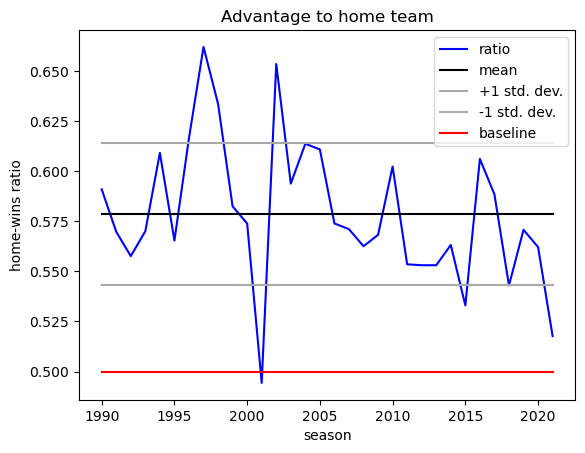

In [25]:
plt.plot(all_seasons, ratios, 'b')
plt.plot(all_seasons, [mu] * len(ratios), 'k')
plt.plot(all_seasons, [mu + sigma] * len(ratios), 'darkgrey')
plt.plot(all_seasons, [mu - sigma] * len(ratios), 'darkgrey')
plt.plot(all_seasons, [0.5] * len(ratios), 'r')
plt.xlabel('season')
plt.ylabel('home-wins ratio')
plt.title('Advantage to home team')
plt.legend(['ratio', 'mean', '+1 std. dev.', '-1 std. dev.', 'baseline'])
plt.show()

Apart from one anomalous season where teams tended to lose their home matches, there does in general appear to be a distinct advantage for a team to play on its home ground. 

### Bernoulli regression

Given the Boolean proposition operator $\texttt{is_home}(\cdot)$,
we may take the per-team features as $x_A=\delta[\texttt{is_home}(A)]$ and $x_B=\delta[\texttt{is_home}(B)]$.
However, since a home match for one team implies an away match for the other team, 
then the simple logistic
two-team model
\begin{eqnarray}
p_A & ~=~ & \sigma[\beta\,(x_A-x_B)]\,,
\end{eqnarray}
with weight $\beta\approx\sigma^{-1}(0.5787)~\approx~0.3174$,
reduces to the
one-team model
\begin{eqnarray}
p_A & ~=~ & \sigma[\beta\,(2x_A-1)]~=~\sigma(\beta\,x_A')\,,
\end{eqnarray}
where $x_A'=+1$ for a home game for team A, and $x_A'=-1$ for an away game.
This form implies that we do not need to fit an intercept. Indeed,
if we do not know in advance (prior to receiving any match information) whether team A
will be playing a home match or an away match, then the prior expectation is $\mathbb{E}[x_A']=0$.
In practice, there should be around the same number of home games as away games, so
we expect that $\langle x_A'\rangle\approx 0$, meaning that
a fitted intercept $\alpha$ will have a value close to zero, and the slope $\beta$ will be approximately the same whether or not an intercept is fitted.

In the following analysis we shall only consider matches in the minor rounds of each season, for
which each team plays each match either at its home ground or at an away ground. 
However, note that in the finals rounds, no teams (supposedly) play at their home ground. Consequently, we would set $x'_A=0$ for these matches, which corresponds to having no information about home-ground status.

In [26]:
X = []
Y = []

df_minor = df_matches[df_matches['round'].str.startswith('R')]
for match in df_minor.itertuples():
    # 'For' team
    x = 2 * float(match.for_is_home) - 1
    y = 0.5 * (1 + match_tools.get_match_result(match, is_for=True))
    X.append(x)
    Y.append(y)
    # 'Against' team
    x = 2 * float(match.against_is_home) - 1
    y = 0.5 * (1 + match_tools.get_match_result(match, is_for=False))
    X.append(x)
    Y.append(y)

Y = np.array(Y)
X = np.array(X)

Firstly, for demonstration purposes, we fit a model with an intercept.

In [33]:
br = BernoulliDistribution().regressor()
Z = add_intercept(X)
print('Fit:', br.fit(Y, Z))
print('Params:', br.regression_parameters())

Fit: (-0.6807331525357341, 2, 8.415503001124591e-07)
Params: [1.57625114e-09 3.17115129e-01]


Next, we fit the model without an intercept.

In [34]:
br = BernoulliDistribution().regressor()
Z = no_intercept(X)
print('Fit:', br.fit(Y, Z))
print('Params:', br.regression_parameters())

Fit: (-0.680733152535734, 2, 8.39085082193769e-07)
Params: [0.31711513]


Observe that, as discussed above, the intercept $\alpha$ is close to zero, and the slope $\beta$ is approximately the same regardless of whether or not an intercept is fitted. Henceforth, if there is a good theoretical reason to suppose that $\alpha=0$, then we shall not bother to fit an intercept.

We also see that we obtain a coefficient of around 0.3171, which is close to our guess of 0.3174, and thus the model reproduces the statistical effect of a home-ground advantage.

Finally, we demonstrate that the model correctly predicts the mean probability of winning the next match given
winning or losing the previous match, respectively.

In [43]:
Z_test = no_intercept([1, -1])
br.mean(Z_test)

array([0.57862103, 0.42137897])

## Previous match result

A simple rule of thumb for modelling is to assume *business as usual*. Thus, in the context of match prediction, we might assume that if a team won/lost its previous match, then it might be likely to win/lose its next match (all other factors being equal). This effectively assumes that the team has some underlying measure of ability which persists over the season.

### Evidence for an effect
<a id="evidence-prev-match">

In [44]:
df = pd.DataFrame(columns=[LOSS, DRAW, WIN], index=[LOSS, DRAW, WIN])
df.fillna(0, inplace=True)

In [45]:
for match in df_matches.itertuples():
    for is_for in [False, True]:
        team = match_tools.get_match_team(match, is_for) 
        res = match_tools.get_match_result(match, is_for)
        prev_match = match_tools.get_previous_match(df_matches, match, is_for)
        if prev_match is None:
            continue
        prev_team = match_tools.get_match_team(prev_match, is_for=True)
        prev_res = match_tools.get_match_result(prev_match, prev_team == team)
        df.iloc[prev_res + 1, res + 1] += 1

In [46]:
print("predictor (row) vs predicted (column)")
df

predictor (row) vs predicted (column)


,loss,draw,win
loss,3077,57,2576
draw,60,1,40
win,2710,46,3228


We see that the 'business as usual' rule appears to hold, such that a previous win/loss is indicative of a future win/loss.
However, we also observe that draws are rare events, and as such are not reliable predictors. Thus, we treat each previous draw as both half-a-win and half-a-loss.

In [47]:
def compute_result_ratio(df_matches):
    df = pd.DataFrame(columns=[LOSS, DRAW, WIN], index=[LOSS, DRAW, WIN])
    df.fillna(0, inplace=True)
    for match in df_matches.itertuples():
        for is_for in [False, True]:
            team = match_tools.get_match_team(match, is_for) 
            res = match_tools.get_match_result(match, is_for)
            prev_match = match_tools.get_previous_match(df_matches, match, is_for)
            if prev_match is None:
                continue
            prev_team = match_tools.get_match_team(prev_match, is_for=True)
            prev_res = match_tools.get_match_result(prev_match, prev_team == team)
            df.iloc[prev_res + 1, res + 1] += 1
    # Treat each draw as half-loss, half-win
    df = df.astype(float)
    df.loc[LOSS,:] += 0.5 * df.loc[DRAW,:]
    df.loc[WIN,:] += 0.5 * df.loc[DRAW,:]
    df.drop(index=DRAW, inplace=True)
    df[LOSS] += 0.5 * df[DRAW]
    df[WIN] += 0.5 * df[DRAW]
    df.drop(columns=DRAW, inplace=True)
    wins = df[WIN]
    losses = df[LOSS]
    df[RATIO] = wins / (wins + losses)
    return df

In [48]:
df = compute_result_ratio(df_matches)
df

,loss,win,wins_ratio
loss,3135.75,2624.75,0.455646
win,2763.25,3271.25,0.542091


In [49]:
p = df.loc[LOSS, RATIO]
q = 1 - p
n = df.loc[LOSS, WIN] + df.loc[LOSS, LOSS]
se = np.sqrt(p * q / n)
print(f"Prob(loss|loss) = {q}, Prob(win|loss) = {p}")
print(f"mean +/- std.err. = ({p-se}, {p+se})")

Prob(loss|loss) = 0.544353788733617, Prob(win|loss) = 0.4556462112663831
mean +/- std.err. = (0.44908438970523673, 0.4622080328275295)


In [50]:
p = df.loc[WIN, RATIO]
q = 1 - p
n = df.loc[WIN, WIN] + df.loc[WIN, LOSS]
se = np.sqrt(p * q / n)
print(f"Prob(loss|win) = {q}, Prob(win|win) = {p}")
print(f"mean +/- std.err. = ({p-se}, {p+se})")

Prob(loss|win) = 0.45790869168945236, Prob(win|win) = 0.5420913083105476
mean +/- std.err. = (0.5356776618042988, 0.5485049548167965)


It would seem that there is evidence of an effect of the previous match result on the next match result.

### Seasonal comparison

In [51]:
win_ratios = []
loss_ratios = []

for season in all_seasons:
    in_season = df_matches.season == season
    df = compute_result_ratio(df_matches[in_season])
    win_ratios.append(df.loc[WIN, RATIO])
    loss_ratios.append(df.loc[LOSS, RATIO])

win_mu = np.mean(win_ratios)
win_sigma = np.std(win_ratios)
print(f"P(win|win): mean = {win_mu}, std. dev. = {win_sigma}")

loss_mu = np.mean(loss_ratios)
loss_sigma = np.std(loss_ratios)
print(f"P(win|loss): mean = {loss_mu}, std. dev. = {loss_sigma}")

P(win|win): mean = 0.5422483911343658, std. dev. = 0.025016791662732314
P(win|loss): mean = 0.45542166039153154, std. dev. = 0.02574375662287661


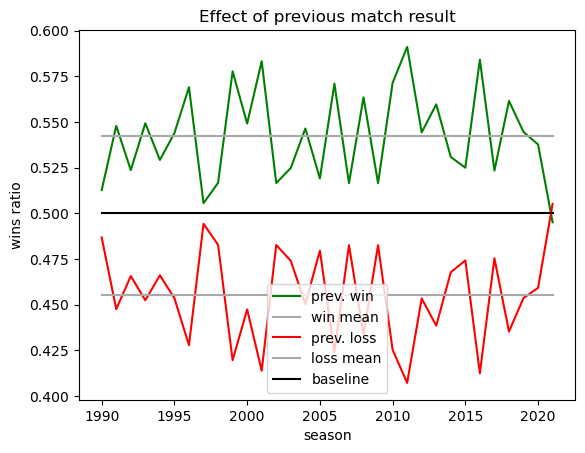

In [52]:
plt.plot(all_seasons, win_ratios, 'green')
plt.plot(all_seasons, [win_mu] * len(ratios), 'darkgrey')
plt.plot(all_seasons, loss_ratios, 'red')
plt.plot(all_seasons, [loss_mu] * len(ratios), 'darkgrey')
plt.plot(all_seasons, [0.5] * len(ratios), 'black')
plt.xlabel('season')
plt.ylabel('wins ratio, $P[win_{cur}|res_{prev}$')
plt.title('Effect of previous match result')
plt.legend(['prev. win', 'win mean', 'prev. loss', 'loss mean', 'baseline'])
plt.show()

Observe that the probability of a win given a previous loss (the red curve) appears to mirror
the probability of a win given a previous win (the green curve). To see why this might be so,
consider the predictive model
\begin{eqnarray}
P(\texttt{win}_\texttt{cur}) & = & 
P(\texttt{win}_\texttt{cur}\mid\texttt{win}_\texttt{prev})\,P(\texttt{win}_\texttt{prev})
+P(\texttt{win}_\texttt{cur}\mid\texttt{loss}_\texttt{prev})\,P(\texttt{loss}_\texttt{prev})
\,.
\end{eqnarray}
Now, we recall that the prior probability of an arbitrary team winning an arbitrary match is 0.5. Hence, taking
$P(\texttt{win}_\texttt{cur})=P(\texttt{loss}_\texttt{cur})=0.5$ and 
$P(\texttt{win}_\texttt{prev})=P(\texttt{loss}_\texttt{prev})=0.5$, it then follows
that
\begin{eqnarray}
P(\texttt{win}_\texttt{cur}\mid\texttt{win}_\texttt{prev})+P(\texttt{win}_\texttt{cur}\mid\texttt{loss}_\texttt{prev})
& ~=~ & 1\,,
\end{eqnarray}
which explains the apparent mirroring of the graph.
Additionally, by subtracting the last term from both sides, 
it further follows that
\begin{eqnarray}
P(\texttt{win}_\texttt{cur}\mid\texttt{win}_\texttt{prev}) & ~=~ & 
P(\texttt{loss}_\texttt{cur}\mid\texttt{loss}_\texttt{prev})
\,.
\end{eqnarray}
This latter equivalence is also (approximately) demonstrated by the
[previous](#evidence-prev-match "Evidence for an effect")
results.

### Bernoulli regression

For a one-team logistic model, the previous mirror identity becomes
\begin{eqnarray}
\sigma(\alpha+\beta\,x_\texttt{win})+\sigma(\alpha+\beta\,x_\texttt{loss}) & ~=~ & 1\,,
\end{eqnarray}
which must hold in general for arbitrary $\alpha$ and $\beta$. The simplest such model is to choose
$\alpha=0$ (see below), with $x_\texttt{loss}=-x_\texttt{win}$.
Consequently, the encoded result of the previous match, namely 
$x_A=+1$ for a win, and $x_A=-1$ for a loss, can be directly used as a feature in the one-team logistic model. We choose $x_A=0$ for a draw.

Note that we have chosen not fit an intercept. This may be justified on theoretical grounds.
If we do not yet know if a team won or lost its previous match, then we should give each possibility an equal prior weight, such that $\mathbb{E}[x_A]=0$. 
Note that the prior probability of a draw has no effect, since we chose $x_A=0$ in this case for consistency. Hence, a draw is taken to mean that we have no evidence for or against the team in regards to winning the next match.

In practice, there is no constraint that each team must have won and lost exactly half each of its previous matches. However, as we shall see below, empircally we do have $\langle x_A\rangle\approx 0$, anyway.
Thus, we do not need an intercept on either practical grounds or theoretical grounds.

In [53]:
Y = []
X_home = []
X_prev = []

for season in all_seasons:
    df_season = df_minor[df_minor.season == season]
    for match in df_season.itertuples():
        for is_for in [False, True]:
            team = match_tools.get_match_team(match, is_for) 
            res = match_tools.get_match_result(match, is_for)
            prev_match = match_tools.get_previous_match(df_season, match, is_for)
            if prev_match is None:
                continue
            prev_team = match_tools.get_match_team(prev_match, is_for=True)
            prev_res = match_tools.get_match_result(prev_match, prev_team == team)
            y = 0.5 * (1 + res)
            Y.append(y)
            x_prev = 1.0 * prev_res
            X_prev.append(x_prev)
            cur_home = match_tools.get_match_home(match, is_for)
            x_home = 2.0 * cur_home - 1
            X_home.append(x_home)

Y = np.array(Y)
X_prev = np.array(X_prev)
X_home = np.array(X_home)

In [54]:
br = BernoulliDistribution().regressor()
Z = no_intercept(X_prev)
print('Fit:', br.fit(Y, Z))
print('Params:', br.regression_parameters())

Fit: (-0.688444123936726, 2, 4.621151972195037e-08)
Params: [0.19529062]


In [56]:
Z_test = no_intercept([1, -1])
print('Means:', br.mean(Z_test))

Means: [0.54866808 0.45133192]


In [57]:
np.mean(X_prev)

-9.136592051164915e-05

As discussed above, observe that the mean of the covariate is close to zero, indicating that we do not need an intercept term in the regression model.

## Gaps between matches

When considering the minor rounds of AFL matches, sometimes a team will not play a match for a round, effectively having a week off. This is known as a '*bye*'. Note that it is possible (but unusual) for a team to have byes for two consecutive rounds.

There are several competing hypotheses regarding byes. One hypothesis is that a bye has a positive effect, for example the team will have a rest and come back stronger the next week. Another hypothesis is that a bye has a negative effect, with the gap disrupting momentum, for example by breaking a winning streak. The *null* hypothesis is that a bye has no effect. 

### Evidence of an effect

Firstly, we look at whether a bye in the previous round has an influence on the match result of the following round.

In [58]:
index_map = {'L': 0, 'D': 1, 'W': 2}
counts = [0] * len(index_map)
for sequence in df_sequences.sequence:
    _iter = iter(sequence)
    prev = next(_iter)
    for cur in _iter:
        if prev == 'B' and cur != 'B':
            counts[index_map[cur]] += 1
        prev = cur

In [59]:
counts = np.array(counts).reshape((1, -1))
df = pd.DataFrame(counts, columns=[LOSS, DRAW, WIN], index=['bye'])
print("Previous round vs current round")
print(df)

adj_losses = counts[0,0] + 0.5 * counts[0,1]
adj_wins = counts[0,2] + 0.5 * counts[0,1]

n = adj_wins + adj_losses
p = adj_wins / n
q = 1 - p
se = np.sqrt(p * q / n)
print()
print(f"Prob(loss|bye) = {q}, Prob(win|bye) = {p}")
print(f"mean +/- std.err. = ({p-se}, {p+se})")

Previous round vs current round
     loss  draw  win
bye   177     3  168

Prob(loss|bye) = 0.5129310344827587, Prob(win|bye) = 0.4870689655172414
mean +/- std.err. = (0.46027511713104374, 0.513862813903439)


It would appear that a bye doesn't really have much of an effect on the next match result. So now we turn to examining the effect a bye has on breaking a streak. Rather than pursue a full sequence analysis here, we merely
look at the relationship between the match before a bye and the match after the bye.
For convenience, we neglect cases with consecutive byes.

In [60]:
n = len(index_map)
counts = np.zeros((n, n), dtype=int)
for sequence in df_sequences.sequence:
    _iter = iter(sequence)
    first = next(_iter)
    second = next(_iter)
    for third in _iter:
        if second == 'B' and first != 'B' and third != 'B':
            i = index_map[first]
            j = index_map[third]
            counts[i,j] += 1
        first, second = second, third

In [61]:
df = pd.DataFrame(counts, columns=[LOSS, DRAW, WIN], index=[LOSS, DRAW, WIN])
print("previous result vs following result")
print(df)

previous result vs following result
      loss  draw  win
loss    80     2   76
draw     1     0    0
win     88     1   82


Once again, there does not seem to be much evidence of an effect, due partly to the fact that byes are relatively rare.

## Previous wins ratio

In a [previous](#Previous-match-result "Section: Previous match result") section,
we looked at the effect that winning or losing the previous match had on predicting the outcome of the current match.
Here we instead consider all previous matches in the season (ignoring byes), and look at the adjusted proportion of wins as a possible predictive measure. 

There are several issues which arise when estimating averages from a sequence of observations.
One issue involves temporal homogeneity versus heterogeneity, i.e. are all observations drawn from the same distribution?
We make the simplifying assumption that each team has some underlying but unknown level $\theta$ of performance that remains constant within each season, but which may vary between seasons.
Hence, we assume each match result is the outcome of a Bernoulli process with probability
$\theta$ of a win.

Another issue arises when the sequence grows in length over time. What is the correct estimate
when a sequence is initially empty? How do we prevent a large discontinuity when the first observation
becomes known?
To help ameliorate this problem, we *backoff* the initial estimate with a *prior* estimate, and 
*smooth* subsequent estimates with the same prior value
(see the [Introduction](1_introduction.ipynb#Backoff-and-smoothing "Introduction: Backoff and smoothing")).
We could use a Laplacian prior, which essentially assumes two previous matches, namely a win and a loss. Alternatively, we could use the team's match proportions from the previous season, equivalent to a single prior match. However, for simplicty we here assume a single drawn match for each team at the start of each season.
Thus, if a team has not yet played any previous matches in the current season, then a prior wins ratio of 0.5 (i.e. a draw) is assumed by default (*backoff*). This prior value is then added as a pseudo-observation to all actual observations before averaging (*smoothing*).
Consequently, if team A has already won $w$ matches and lost $\ell=n-w$ matches, then the smoothed
proportion of wins
is just the feature $x_A=\frac{w+0.5}{n+1}$. Note that this is exactly the form of
the [predictive distribution](D_distributions.ipynb#Bernoulli-predictive-distribution
"Appendix D: Bernoulli predictive distribution") of a Bernoulli outcome assuming a 
[Jeffreys' prior](https://en.wikipedia.org/wiki/Jeffreys_prior "Wikipedia: Jeffreys Prior") on the
parameter $\theta$.

The last issue of concern here is also due to the sequence of observations growing in length
as the season progresses. As noted above, if we assume temporal homogeneity, then we anticipate
that the sequence average will eventually tend towards the underlying team performance (assuming unbiased estimates). Thus, the reliability of each estimated proportion of wins improves over time.
Conversely, early estimates are unreliable. How do we account for the reliability of each estimate?

If we observe $w$ wins in $n$ consecutive matches, then the success proportion
$\frac{w}{n}$ will have mean $\theta$ and variance $\frac{\theta\,(1-\theta)}{n}$. Since we do not know $\theta$, we see that a maximum variance 
of $\frac{1}{4n}$ occurs for $\theta=0.5$. Consequently, we may follow the 
weighted least squares (WLS)
approach by weighting each estimate in inverse proportion to its variance, namely the number $n$ of matches used to compute the estimate. Note that the prior pseudo-match is technically not drawn stochastically from the Bernoulli distribution.  However, if we do not include it then
we cannot fit the results of the first match for each team in each season.
Consequently, we take the weight of feature $x_A$, derived from $n$ observed matches, to be $n+1$.

### Evidence of an effect

In [62]:
def get_adjusted_wins(match, is_for):
    # Obtain match result as a Bernoulli value
    res = match_tools.get_match_result(match, is_for)
    return 0.5 * (res + 1)

In [63]:
def get_prev_wins_ratio(match, is_for):
    features = match_tools.get_match_features(df_within, match, is_for)
    if features is None:
        # Assume a prior 'draw' with a pseudo-count of 1 observation
        return 0.5, 1
    # Smooth actual observations with pseudo-count
    wins = 0.5 + features.wins + 0.5 * features.draws
    losses = 0.5 + features.losses + 0.5 * features.draws
    n = wins + losses
    return wins / n, n

In [94]:
cur_wins = []
prev_wins_ratios = []
num_samples = []
for match in df_matches.itertuples():
    for is_for in [False, True]:
        cur_res = get_adjusted_wins(match, is_for)
        cur_wins.append(cur_res)
        wins_ratio, n = get_prev_wins_ratio(match, is_for)
        prev_wins_ratios.append(wins_ratio)
        num_samples.append(n)

In [156]:
def fit_data_beta(X, Y, W=None):
    # Fit Bernoulli response variate with Beta explanatory variate
    print("Fitting Bernoulli regression with Beta covariate...")
    X = np.asarray(X)
    if W is None:
        W = np.ones(len(X))
    Z = add_intercept(np.log(X), np.log(1-X))
    br = BernoulliDistribution().regressor()
    print('Fit:', br.fit(Y, Z, W))
    print('Regression params:', br.regression_parameters())
    # Measure fit
    Y_beta = br.mean(Z)
    print("R^2:", stats_tools.R_squared(Y, Y_beta))
    print("cross-entropy:", stats_tools.cross_entropy(Y, Y_beta))
    print("accuracy:", stats_tools.binary_accuracy(Y, Y_beta))
    # Predict smooth response
    x_values = np.linspace(min(X), max(X), 100)
    z_values = add_intercept(np.log(x_values), np.log(1 - x_values))
    y_beta = br.mean(z_values)
    # Compute data means
    stats = stats_tools.summarise_data(X, Y)
    x_means = stats[1]
    y_means = stats[2]
    y_se = stats[4]
    # Fit cubic for comparison"
    print("---")
    print("Fitting cubic regression...")
    Z2 = no_intercept(X, X**2, X**3)
    reg = LinearRegression().fit(Z2, Y, W)
    print('Independent param:', reg.intercept_)
    print('Regression params:', reg.coef_)
    Y_cubic = reg.predict(Z2)
    print("R^2:", stats_tools.R_squared(Y, Y_cubic))
    print("cross-entropy:", stats_tools.cross_entropy(Y, Y_cubic))
    print("accuracy:", stats_tools.binary_accuracy(Y, Y_cubic))
    z_values = no_intercept(x_values, x_values**2, x_values**3)
    y_cubic = reg.predict(z_values)
    # Return standard plot data
    return [
        (X, Y, 'o', 'data'),
        (x_values, y_cubic, 'b', 'cubic'),
        (x_values, y_beta, 'r', 'Bernoulli'),
        (x_means, y_means, 'k', 'bin mean'),
        (x_means, y_means + 2 * y_se, 'darkgrey', '2 std. err.'),
        (x_means, y_means - 2 * y_se, 'darkgrey', None)    
    ]

In [96]:
data = fit_data_beta(prev_wins_ratios, cur_wins, num_samples)

Fitting Bernoulli regression with Beta covariate...
Fit: (-0.6716532656632208, 3, 1.3743414073452698e-08)
Regression params: [ 0.24440214  0.61173207 -0.28326267]
R^2: 0.04268744292105442
cross-entropy: 0.6716532656632208
accuracy: 0.5837925445705024
---
Fitting cubic regression...
Independent param: 0.16169488654128122
Regression params: [ 0.56384902  0.49120261 -0.52666942]
R^2: 0.04168612252500714
cross-entropy: 0.6722197217611464
accuracy: 0.5837925445705024


In [97]:
def plot_data(data):
    ls = []
    for x, y, c, l in data:
        plt.plot(x, y, c)
        if l is not None:
            ls.append(l)
    plt.legend(ls)

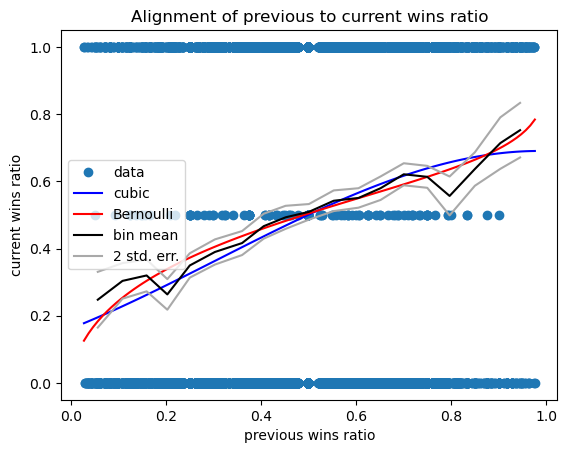

In [98]:
plot_data(data)
plt.xlabel('previous wins ratio')
plt.ylabel('current wins ratio')
plt.title('Alignment of previous to current wins ratio')
plt.show()

We observe that there seems to be a positive correlation between the previous wins ratio and the probability of
winning the current match. We also see that the previous wins ratio is less trustworthy at the extremes.
Finally, note that the 'bumps' around 0.2 and 0.8 might be related to the prior smoothing. For example, consider the first match for a team in any season. If the team wins, then the wins ratio will be smoothed to 
$\frac{0.5+1}{1+1}=0.75$. However, if the team loses then the smoothed estimate will be 
$\frac{0.5+0}{1+1}=0.25$.

For the purposes of comparison, we shall always fit a simple cubic model alongside the Bernoulli regression model.
Unlike the latter model, the former model is unconstrained and can produce predictive values outside the range $[0,1]$.
However, in practice we observe that there is little difference between the two models, except at the end-points of
the interval. However, it is precisely at these end-points that there are the fewest observations and the greatest uncertainty. Consequently, either model might be acceptable in practice.

## Previous points ratio

As noted 
[earlier](#One-team-vs-two-team-modelling "Section: One-team vs two-team modelling"),
the points ratio for team A in a single match against team B is given by
\begin{eqnarray}
p_A & = & \frac{f_A}{f_A+f_B}~=~\frac{f_A}{f_A+a_A}\,,
\end{eqnarray}
where $f_A=a_B$ is the number of points scored by team A against team B, and $f_B=a_A$ is the number of points scored 
by team B against team A.
Now, taking the logit transform, we observe that
\begin{eqnarray}
\sigma^{-1}(p_A) &~=~& \ln\left[\frac{p_A}{1-p_A}\right]~=~\ln f_A-\ln f_B~=~\ln f_A-\ln a_A\,.
\end{eqnarray}
To interpret this relation, we note that if team A has a strong offense then we would expect them to score a relatively high number $f_A$ of points against their opponent (team B) Hence, $\ln f_A$ is an indirect measure of team A's offensive strength,
since it increases as $f_A$ increases. Similarly, if team A has a strong defense, then we would expect them to have a relatively low number $a_A$ of points scored against them.
Hence, $-\ln a_A$ is an indirect measure of team A's defensive strength, since it increases as $a_A$ decreases.
The sum of the offensive strength and the defensive strength gives a total, *effective* strength. Note that this effective strength is just $\ln f_A-\ln f_B$, and so it is relative to team B's effective strength of $\ln f_B-\ln a_B$.

Next we turn to the points ratio from previous matches as a pontential predictor for $p_A$.
Supoose that team A has played $n_A$ previous matches in the current season, and has so far scored a total of $F_A$ points,
and had a total for $A_A$ points scored against them. Firstly, we need to allow for the case of $n_A=0$ previous matches.
To do so, we assume a single, prior pseudo-match in which both opposing teams scored some fictional number $f_0$ of points,
and we smooth the observed points scored.
We shall derive a value for $f_0$ is the [following](#Prior-points-scored "Section: Prior points scored") section. 
Secondly, to provide scores comparable to $f_A$ and
$a_A$, we compute the per-match averaged scores as
\begin{eqnarray}
\bar{f}_A~\doteq~\frac{f_0+F_A}{1+n_A}\,, &\;\;\;\; & \bar{a}_A~\doteq~\frac{f_0+A_A}{1+n_A}\,,
\end{eqnarray}
respectively. The previous points ratio is then defined as
\begin{eqnarray}
x_A &~\doteq~& \frac{\bar{f}_A}{\bar{f}_A+\bar{a}_A}\,.
\end{eqnarray}
We may interpret this as saying that in a match between team A and some arbitrary opponent, if some total number 
$S=f_A+a_A$ of 
points is scored in the match, then we expect $S\,x_A$ of those points to be
scored by team A. Thus, if $x_A>0.5$, we expect team A to be more likely to win the match than lose it. The actual value of $x_A$ indicates our confidence in this prediction.

Finally, note that the logit transform of this points ratio gives
\begin{eqnarray}
y_A &~\doteq~& \sigma^{-1}(x_A)~=~\ln\bar{f}_A-\ln\bar{a}_A~=~(\ln\bar{f}_A-\ln f_0)+(\ln f_0-\ln\bar{a}_A)\,,
\end{eqnarray}
such that the last two terms measure the offensive and defensive strengths of team A, respectively, relative to the
prior score $f_0$, and their sum estimates the total effective strength of team A.

Returning to the current match between teams A and B, we may suppose that the stronger team B's defense, the fewer points team A will manage to score against them. Hence, we deduce that the expected strength of team A is related to
the difference between team A's offsensive strength and team B's defensive strength, namely
\begin{eqnarray}
\ln\hat{f}_A & ~\doteq~ &
%\mathbb{E}[\ln f_A] ~=~ 
\ln f_0+(\ln\bar{f}_A-\ln f_0)-(\ln f_0-\ln\bar{a}_B)~=~\ln\bar{f}_A+\ln\bar{a}_B-\ln f_0\,.
\end{eqnarray}
Similarly, we have
\begin{eqnarray}
\ln\hat{f}_B & ~\doteq~ &
%\mathbb{E}[\ln f_B] ~=~ 
\ln f_0+(\ln\bar{f}_B-\ln f_0)-(\ln f_0-\ln\bar{a}_A)~=~\ln\bar{f}_B+\ln\bar{a}_A-\ln f_0\,,
\end{eqnarray}
for team B's estimated effective strength.
Consequently, we find (via rearrangement of terms) that
\begin{eqnarray}
\ln\hat{f}_A-\ln\hat{f}_B & ~\equiv~ &
(\ln\bar{f}_A-\ln\bar{a}_A)-(\ln\bar{f}_B-\ln\bar{a}_B)~=y_A-y_B\,.
\end{eqnarray}
Now, defining the expected points ratio as
\begin{eqnarray}
\hat{x}_A & ~\doteq~ & \frac{\hat{f}_A}{\hat{f}_A+\hat{f}_B}\,,
\end{eqnarray}
we observe (via the logit transform) that the above relation reduces to
\begin{eqnarray}
\sigma^{-1}(\hat{x}_A) & = & \sigma^{-1}(x_A)-\sigma^{-1}(x_B)\,.
\end{eqnarray}
Observe that this is just a two-team logistic model that contrasts the total effective strengths of teams A and B.

### Prior points scored

As discussed [above](#Previous-points-ratio "Section: Previous points ratio"), 
we smooth the observed number of points scored per match to allow for a prior value when no previous matches
have yet been played. What is a suitable prior number $f_0$ of points?
In order to decide this, we examine the distribution of the number of points per team per match.

Note that we usually assume, for convenience, that the length of every match is approximately the same, i.e.
about 20 minutes each for the four quarters of a match.
However, it must be noted that prior to 1994, the alotted time was actually 25 minutes per quarter.
Also, due to the outbreak of Covid in 2020, the time was reduced for that season to only 16 minutes per quarter.
Consequently, we need to adjust the pre-1994 and the 2020 season results to standardise the unit of time.

In [84]:
from scipy import stats as sci_stats

In [85]:
Y = []
for match in df_matches.itertuples():
    for y in [match.for_total_score, match.against_total_score]:
        if match.season == 2020:
            y *= 20 / 16
        elif match.season < 1994:
            y *= 20 / 25
        Y.append(y)
df = pd.DataFrame({'points': Y})

In [86]:
alpha, loc, beta = sci_stats.gamma.fit(Y)
x_values = np.linspace(min(Y), max(Y), 100)
y_values = sci_stats.gamma.pdf(x_values, alpha, loc=loc, scale=beta)

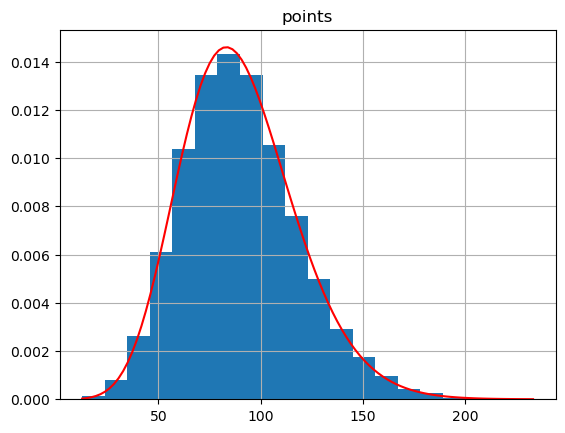

In [87]:
res = df.hist(bins=20, density=True)
ax = res[0][0]
res = ax.plot(x_values, y_values, 'r')

It would seem that the total number of points per team per match appears to follow a Gamma distribution. 

In [88]:
print(f"points score: mean={np.mean(Y)}, mode={sci_stats.mode(Y)[0]}", end=", ")
print(f"min={np.min(Y)}, max={np.max(Y)}")

points score: mean=89.89792139384117, mode=100.0, min=12.8, max=233.0


Observe that the expected number of points per team per match is around 90.
We could therefore take this as the prior score $f_0$ of the pseudo-match for each team at the start of each season.

For interest, we also examine the (adjusted) average points per match over time.

In [90]:
points_per_season = {}
for match in df_matches.itertuples():
    season = match.season
    num_matches, num_points, num_adj_points = points_per_season.get(season, (0, 0, 0))
    for y in [match.for_total_score, match.against_total_score]:
        num_matches += 1
        num_points += y
        if season == 2020:
            y *= 20 / 16
        elif season < 1994:
            y *= 20 / 25
        num_adj_points += y
    points_per_season[season] = (num_matches, num_points, num_adj_points)
seasons = sorted(points_per_season.keys())
values = [points_per_season[s] for s in seasons]
avg_points = np.array([v[1] / v[0] for v in values])
avg_adj_points = np.array([v[2] / v[0] for v in values])

In [91]:
mu = np.mean(avg_adj_points)
sd = np.sqrt(np.var(avg_adj_points))

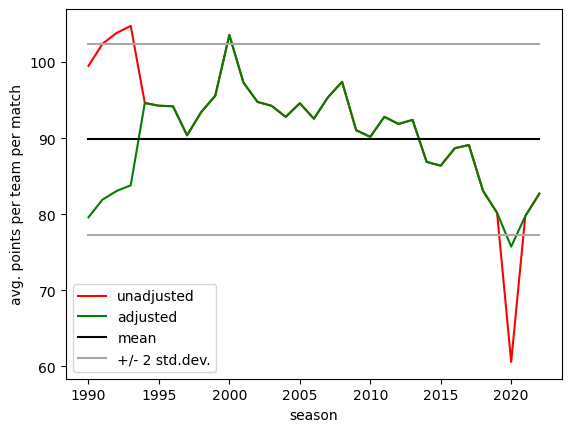

In [92]:
plt.plot(seasons, avg_points, 'r')
plt.plot(seasons, avg_adj_points, 'g')
plt.plot(seasons, [mu] * len(seasons), 'k')
plt.plot(seasons, [mu + 2 * sd] * len(seasons), 'darkgrey')
plt.plot(seasons, [mu - 2 * sd] * len(seasons), 'darkgrey')
plt.xlabel("season")
plt.ylabel("avg. points per team per match")
plt.legend(['unadjusted', 'adjusted', 'mean', '+/- 2 std.dev.'])
plt.show()

We clearly observe the anomalous effect of Covid on the 2020 season, even after adjustment for the different lengths of quarters. We also see that the 2000 season had an unuasually high average number of points per match.
Overall, apart from the pre-1994 effect, it seems that the average number of points scored per match for any team is possibly declining over time.
This might be explained by ongoing changes to the AFL rules designed to reduce physical injury to players, such as more severely penalising body tackles, et cetera. Having more penalties awarded acts to slow down play, which might be expected to result in lower scores. However, most of the seasonal averages are within expected bounds, so these apparent differences could just be random fluctuations about the mean.

### Evidence of an effect

We see from above that there are two ways of computing the points ratio. In method 1, we predict $\hat{f}_A$ and $\hat{f}_B$
using the combined offensive and defensive measures from team A versus team B (i.e. offense for team A minus defense for team B, and vice versa), and then form the predicted points ratio
\begin{eqnarray}
\hat{x}_A & \doteq & \frac{\hat{f}_A}{\hat{f}_A+\hat{f}_B}\,,
\end{eqnarray}
and its complement $\hat{x}_B$.
In method 2, we separately use the previous points ratios from each team, i.e.
\begin{eqnarray}
x_A & \doteq & \frac{\bar{f}_A}{\bar{f}_A+\bar{a}_A}\,,
\end{eqnarray}
and its complement $x_B$.
We briefly examine the relationship between the actual wins ratio $p_A$ for team A and both the predicted points ratio,
$\hat{x}_A$, and the previous points ratio, $x_A$.
[Recall](#Previous-points-ratio "Section: Previous points ratio") 
that the two approaches are related by the fact that
\begin{eqnarray}
\sigma^{-1}(\hat{x}_A)
&~=~&\ln\hat{f}_A-\ln\hat{f}_B~=~(\ln\bar{f}_A-\ln\bar{a}_A)-(\ln\bar{f}_B-\ln\bar{a}_B)
~=~\sigma^{-1}(x_A)-\sigma^{-1}(x_B)\,.
\end{eqnarray}
Thus, method 1 corresponds to a two-team model, and method 2 corresponds to a one-team model.

Finally, recall from the 
[previous](#Prior-points-scored "Section: Prior points scored") 
section that $f_A$ appears to have a Gamma distribution, say
$f_A\sim\texttt{Gamma}(\alpha,\gamma)$, with some variance $\sigma^2$. We therefore take the variance of
the mean score per match as $\texttt{Var}[\bar{f}_A]=\frac{\sigma^2}{n_A}$, such that we once again use a weighting proportional to $n_A$ (or $n_A+1$ including the
prior match). However, note that when considering a two-team model, we must allow for the fact that each team may have played a different number of previous matches (due to byes).
In this case, we use the pooled variance
\begin{eqnarray}
\texttt{Var}[\bar{f}_{A,B}] & ~\doteq~ & 
\frac{n_A\,\texttt{Var}[\bar{f}_A]+n_B\,\texttt{Var}[\bar{f}_B]}{n_A+n_B}
~=~\frac{2\sigma^2}{n_A+n_B}\,,
\end{eqnarray}
such that the combined weight of the two teams' previous matches is just $n_A+n_B$ (plus an extra prior match for each team).

We first set the prior number $f_0$ of points per match to (approximately) be the mean value. Then we compute the smoothed values of offensive strength and defensive strength for each team, obtained from previous matches, and use these values to predict the points ratios
for each team.

In [99]:
f_0 = 90    # mean and prior score
ln_f0 = np.log(f_0)

In [100]:
def get_prev_points_features(match, is_for):
    features = match_tools.get_match_features(df_within, match, is_for)
    if features is None:
        # Assume a prior 'draw' with a pseudo-count of 1 match
        n_A = 1
        off_A = 0.0
        def_A = 0.0
        x_A = 0.5
    else:
        # Smooth actual observations with pseudo-points
        n_A = 1 + features.games
        f_A = f_0 + features.points_for
        a_A = f_0 + features.points_against
        off_A = np.log(f_A / n_A) - ln_f0
        def_A = ln_f0 - np.log(a_A / n_A)
        x_A = f_A / (f_A + a_A)
    return off_A, def_A, x_A, n_A

In [101]:
Y = []   # wins ratio
X2 = []  # predicted points ratio from both teams
X1 = []  # previous points ratio
num_samples1 = []  # single team matches
num_samples2 = []  # both team matches
_offenses = np.zeros(2, dtype=float)
_defenses = np.zeros(2, dtype=float)
for match in df_matches.itertuples():
    both_teams = 2
    for is_for in [False, True]:
        cur_res = get_adjusted_wins(match, is_for)
        Y.append(cur_res)
        offense, defense, points_ratio, n = get_prev_points_features(match, is_for)
        num_samples1.append(n)
        both_teams += n
        X1.append(points_ratio)
        i = int(is_for)
        _offenses[i] = offense
        _defenses[i] = defense
    x = np.exp(ln_f0 + _offenses - _defenses[::-1])
    x /= x.sum()
    X2.extend(x)
    num_samples2.extend([both_teams] * 2)

In [102]:
data = fit_data_beta(X2, Y, num_samples2)

Fitting Bernoulli regression with Beta covariate...
Fit: (-0.6296456800624946, 4, 4.9079629249604295e-12)
Regression params: [-2.83157204e-13  2.76556721e+00 -2.76556721e+00]
R^2: 0.12045983845400621
cross-entropy: 0.6296456800624946
accuracy: 0.6402755267423015
---
Fitting cubic regression...
Independent param: 1.9243856763613607
Regression params: [-14.73324744  35.65342826 -23.76895217]
R^2: 0.11887059263753408
cross-entropy: 0.6306903771700814
accuracy: 0.6402755267423015


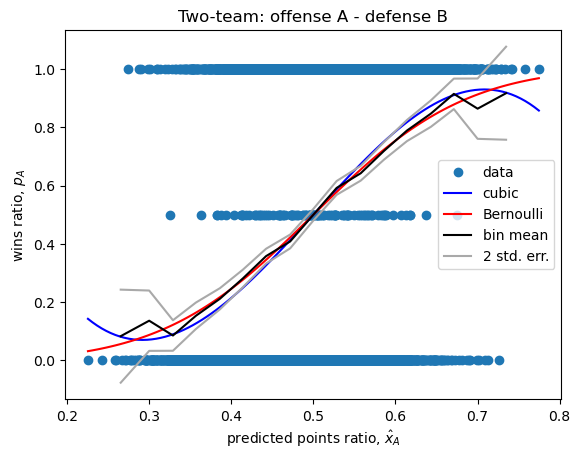

In [103]:
plot_data(data)
plt.xlabel("predicted points ratio, $\hat{x}_A$")
plt.ylabel("wins ratio, $p_A$")
plt.title("Two-team: offense A - defense B")
plt.show()

In [104]:
data = fit_data_beta(X1, Y, num_samples1)

Fitting Bernoulli regression with Beta covariate...
Fit: (-0.664362409247828, 3, 1.8495744558144622e-07)
Regression params: [4.07621456 5.30500927 0.56901653]
R^2: 0.05645540675425098
cross-entropy: 0.664362409247828
accuracy: 0.5905996758508915
---
Fitting cubic regression...
Independent param: 3.0659122430468537
Regression params: [-22.36695523  53.107052   -37.3146505 ]
R^2: 0.055834703178017864
cross-entropy: 0.664658106951756
accuracy: 0.5899513776337115


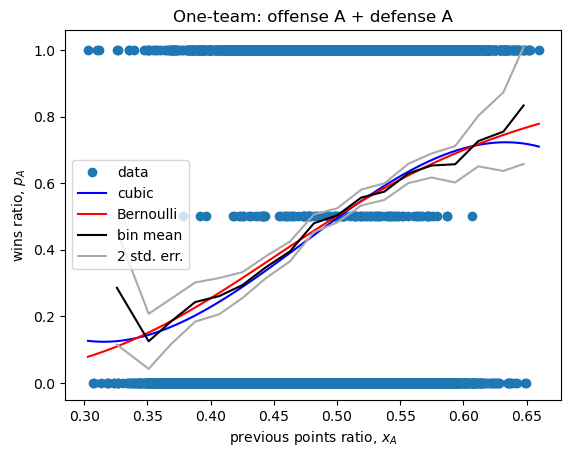

In [105]:
plot_data(data)
plt.xlabel("previous points ratio, $x_A$")
plt.ylabel("wins ratio, $p_A$")
plt.title("One-team: offense A + defense A")
plt.show()

We observe that the two-team model fits the data slightly better than the one-team model, 
as evidenced by the higher $R^2$ score and lower cross-entropy score, despite both models having the same number of parameters.
In addition, the two-team model has a higher accuracy of about 64%, compared to about 59% for the one-team model.
This demonstrates the benefit of taking into account information about both teams in a match.

Note that the two-tem model does not require an intercept, and its feature weights sum to zero, indicating that use of a logit feature, i.e. $\hat{y}_A\doteq\sigma^{-1}(\hat{x}_A)=y_A-y_B$, is a reasonable assumption.
In contrast, the one-team model does require an intercept, and has unrelated feature weights, indicating that
symmetry has been broken and that use of $y_A\doteq\sigma^{-1}(x_A)$ as the sole feature is not sufficient.
Also note that the cubic model is not suitable in this instance due to it exhibiting turning points at the ends of the interval, which breaks our expectation of monotonicity.

## Team ranking

It seems reasonable to expect that a stronger team should be likely to defeat a weaker team. In previous sections, we have
used various features as proxies for the subjective measure of team strength. Here we shall use the ranking of each team on the league ladder prior to any given match. Technically these rankings are only computed during the minor rounds in each season, with the final rankings being used to allot team matches in the finals rounds, e.g. qualification and elimination rounds, et cetera.

We recall that the number of teams in the league may vary from season to season, and hence we use the adjusted rank scores,
which were computed to be 1.0 for the top-ranked team, and 0.0 for the bottom-ranked team.
Since the rank score is (mostly) an increasing function of the
relative number of wins for each team (with allowances for breaking ties), we take the adjusted rank score as
the pseduo-probability of a win. In order to allow for taking logarithms, however, we further adjust the scores
to map the interval $[0,1]$ into $[0.1,0.9]$.

### Evidence of an effect

Firstly, we examine a one-team model with features $x_A=+1$ if team A is ranked higher than the opposing team, and
$x_A=-1$ if team A is ranked lower. A tied rank (which is not technically possible) should be given the value $x_A=0$.
For convenience, since the rankings of each team depend on the number of previous matches played, we again take the combined
weight to be $n_A+n_B$ (this time with no prior matches). In other words, after more matches have been played, we trust the ranks of each team to be a better reflection of their relative strengths.

In [144]:
X_for = []
X_against = []
Y = []
num_samples = []

df_minor = df_matches[df_matches['round'].str.startswith('R')]
for match in df_minor.itertuples():
    for_features = match_tools.get_match_features(df_within, match, is_for=True)
    against_features = match_tools.get_match_features(df_within, match, is_for=False)
    if for_features is None or against_features is None:
        continue
    # Count previous matches for both teams
    n = for_features.games + against_features.games
    for_rank = for_features.rank_score
    for_wins = 0.5 * (1 + match_tools.get_match_result(match, is_for=True))
    against_rank = against_features.rank_score
    X_for.append(for_rank)
    X_against.append(against_rank)
    Y.append(for_wins)
    num_samples.append(n)
    X_for.append(against_rank)
    X_against.append(for_rank)
    Y.append(1 - for_wins)
    num_samples.append(n)

Y = np.array(Y)
X_for = np.array(X_for)
X_against = np.array(X_against)

In [146]:
X = X_for - X_against
df = pd.DataFrame(np.sign(X), columns=["rank_sign"])
df[WIN] = Y == 1.0
df[DRAW] = Y == 0.5
df[LOSS] = Y == 0.0
df = df.groupby('rank_sign').sum()
wins = df[WIN] + 0.5 * df[DRAW]
losses = df[LOSS] + 0.5 * df[DRAW]
df[RATIO] = wins / (wins + losses)
df

,win,draw,loss,wins_ratio
rank_sign,,,,
-1.0,1971,50,3590,0.35573
1.0,3590,50,1971,0.64427


We clearly observe a strong effect whereby the higher ranked team is much more likely to win than to lose.

Next, we examine the effect of the magnitude of the rank score using a one-team model. 

In [153]:
def fit_data_linear(X, Y, W=None):
    # Fit Bernoulli response variate with linear explanatory variate
    print("Fitting Bernoulli regression with linear covariate...")
    X = np.asarray(X)
    if W is None:
        W = np.ones(len(X))
    Z = add_intercept(X)
    br = BernoulliDistribution().regressor()
    print('Fit:', br.fit(Y, Z, W))
    print('Regression params:', br.regression_parameters())
    # Measure fit
    Y_beta = br.mean(Z)
    print("R^2:", stats_tools.R_squared(Y, Y_beta))
    print("cross-entropy:", stats_tools.cross_entropy(Y, Y_beta))
    print("accuracy:", stats_tools.binary_accuracy(Y, Y_beta))
    # Predict smooth response
    x_values = np.linspace(min(X), max(X), 100)
    z_values = add_intercept(x_values)
    y_beta = br.mean(z_values)
    # Compute data means
    stats = stats_tools.summarise_data(X, Y)
    x_means = stats[1]
    y_means = stats[2]
    y_se = stats[4]
    # Fit cubic for comparison"
    print("---")
    print("Fitting cubic regression...")
    Z2 = no_intercept(X, X**2, X**3)
    reg = LinearRegression().fit(Z2, Y, W)
    print('Independent param:', reg.intercept_)
    print('Regression params:', reg.coef_)
    Y_cubic = reg.predict(Z2)
    print("R^2:", stats_tools.R_squared(Y, Y_cubic))
    print("cross-entropy:", stats_tools.cross_entropy(Y, Y_cubic))
    print("accuracy:", stats_tools.binary_accuracy(Y, Y_cubic))
    z_values = no_intercept(x_values, x_values**2, x_values**3)
    y_cubic = reg.predict(z_values)
    # Return standard plot data
    return [
        (X, Y, 'o', 'data'),
        (x_values, y_cubic, 'b', 'cubic'),
        (x_values, y_beta, 'r', 'Bernoulli'),
        (x_means, y_means, 'k', 'bin mean'),
        (x_means, y_means + 2 * y_se, 'darkgrey', '2 std. err.'),
        (x_means, y_means - 2 * y_se, 'darkgrey', None)    
    ]

In [175]:
data = fit_data_linear(X_for, Y, num_samples)

Fitting Bernoulli regression with linear covariate...
Fit: (-0.6672001120250515, 3, 2.0620216645284017e-10)
Regression params: [-0.74031014  1.54529774]
R^2: 0.05137593431444398
cross-entropy: 0.6672001120250515
accuracy: 0.5882195687043308
---
Fitting cubic regression...
Independent param: 0.2233790867021151
Regression params: [ 1.00927544 -0.91693725  0.35160147]
R^2: 0.05445648925757629
cross-entropy: 0.6655863728823601
accuracy: 0.5990019604348601


Observe that the linear Bernoulli model, namely $\hat{p}_A=\sigma(\alpha+\beta\,x_A)$, where $x_A$ is the adjusted rank score, does not fit as well as the simple cubic model. Consequently, we also try an alternative where we
treat $x_A$ as a pseudo-probability, assumed to be sample from a Beta distribution.
However, to avoid problems with the end-points we first map the values from $[0,1]$ to $(0,1)$.

In [176]:
X_adj = 0.8 * X_for + 0.1
data2 = fit_data_beta(X_adj, Y, num_samples)

Fitting Bernoulli regression with Beta covariate...
Fit: (-0.6650865830552241, 3, 6.939522290139166e-09)
Regression params: [ 0.63751561  0.75368035 -0.03509064]
R^2: 0.05532793981487438
cross-entropy: 0.6650865830552241
accuracy: 0.5990019604348601
---
Fitting cubic regression...
Independent param: 0.08220579065223504
Regression params: [ 1.56873884 -1.63873094  0.68672162]
R^2: 0.05445648925757629
cross-entropy: 0.6655863728823601
accuracy: 0.5990019604348601


In [177]:
x_values, y_beta = data2[2][0:2]
x_values = (x_values - 0.1) / 0.8
data.insert(3, (x_values, y_beta, 'g', 'Bernoulli-Beta'))

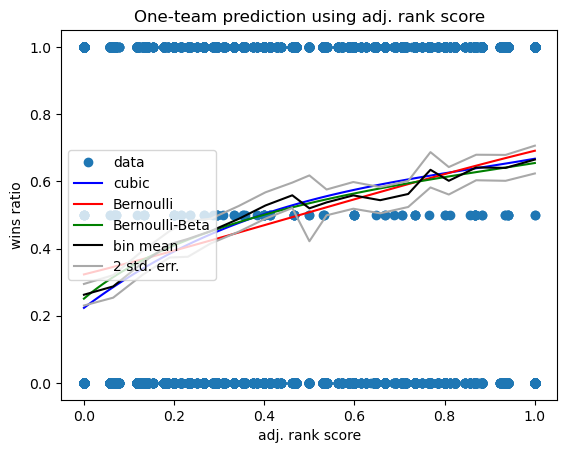

In [178]:
plot_data(data)
plt.xlabel("adj. rank score")
plt.ylabel("wins ratio")
plt.title("One-team prediction using adj. rank score")
plt.show()

Evidently, the appropriate features for the rank score are measured on a logarithmic scale rather than a linear scale.


We now turn to a two-team model, and look at the effect of the difference (in magnitude) between team ranks on the probability of a win forteam A against its opponent. 

In [149]:
data = fit_data_linear(X, Y, num_samples)

Fitting Bernoulli regression with linear covariate...
Fit: (-0.6393627651312598, 3, 1.0322352572700311e-07)
Regression params: [1.45347126e-11 1.64599746e+00]
R^2: 0.10436698315328052
cross-entropy: 0.6393627651312598
accuracy: 0.6442701835679915
---
Fitting cubic regression...
Independent param: 0.5
Regression params: [ 4.80271440e-01  5.55111512e-17 -1.42394855e-01]
R^2: 0.10274994694084305
cross-entropy: 0.6404283215180578
accuracy: 0.6442701835679915


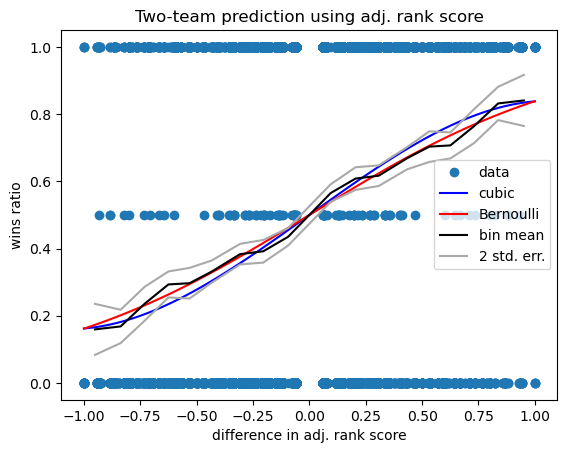

In [151]:
plot_data(data)
plt.xlabel("difference in adj. rank score")
plt.ylabel("wins ratio")
plt.title("Two-team prediction using adj. rank score")
plt.show()

In [132]:
def fit_data2(X_for, X_against, Y, W=None):
    # Fit Bernoulli response variate with Beta explanatory variates
    if W is None:
        W = np.ones(len(Y))
    print("Fitting Bernoulli regression with Beta features...")
    Z = add_intercept(np.log(X_for), np.log(1 - X_for), np.log(X_against), np.log(1 - X_against))
    br = BernoulliDistribution().regressor()
    print('Fit:', br.fit(Y, Z, W))
    print('Regression params:', br.regression_parameters())
    Y_bern = br.mean(Z)
    print("R^2:", stats_tools.R_squared(Y, Y_bern))
    print("cross-entropy:", stats_tools.cross_entropy(Y, Y_bern))
    print("accuracy:", stats_tools.binary_accuracy(Y, Y_bern))
    # Fit Bernoulli response variate with symmetric Beta explanatory variates
    print("---")
    print("Fitting Bernoulli regression with logit features...")
    Z = no_intercept(logit(X_for), logit(X_against))
    br = BernoulliDistribution().regressor()
    print('Fit:', br.fit(Y, Z, W))
    print('Regression params:', br.regression_parameters())
    Y_logit = br.mean(Z)
    print("R^2:", stats_tools.R_squared(Y, Y_logit))
    print("cross-entropy:", stats_tools.cross_entropy(Y, Y_logit))
    print("accuracy:", stats_tools.binary_accuracy(Y, Y_logit))
    # Fit cubic for comparison
    print("---")
    print("Fitting cubic regression...")
    X_diff = X_for - X_against
    Z = no_intercept(X_diff, X_diff**2, X_diff**3)
    reg = LinearRegression(fit_intercept=True).fit(Z, Y, W)
    print("Independent param:", reg.intercept_)
    print("Regression params:", reg.coef_)
    Y_cubic = reg.predict(Z)
    print("R^2:", stats_tools.R_squared(Y, Y_cubic))
    print("cross-entropy:", stats_tools.cross_entropy(Y, Y_cubic))
    print("accuracy:", stats_tools.binary_accuracy(Y, Y_cubic))
    # Return computations
    return X_for, X_against, Y, Y_logit, Y_bern, Y_cubic

In [133]:
data = fit_data2(X_for, X_against, Y, num_samples)

Fitting Bernoulli regression with Beta features...
Fit: (-0.6351739671080685, 3, 3.507960957271905e-07)
Regression params: [-3.56822051e-12  7.67820584e-01 -7.67973570e-02 -7.67820584e-01
  7.67973570e-02]
R^2: 0.11181398113892516
cross-entropy: 0.6351739671080685
accuracy: 0.6442701835679915
---
Fitting Bernoulli regression with logit features...
Fit: (-0.63798337611946, 3, 1.5805365150001194e-07)
Regression params: [ 0.42880321 -0.42880321]
R^2: 0.10686696121308625
cross-entropy: 0.63798337611946
accuracy: 0.6442701835679915
---
Fitting cubic regression...
Independent param: 0.5
Regression params: [ 0.6003393   0.         -0.27811495]
R^2: 0.10274994694084305
cross-entropy: 0.6404283215180578
accuracy: 0.6442701835679915


In [140]:
def plot_data2(data, mode='linear'):
    X_for, X_against, Y, Y_logit, Y_bern, Y_cubic = data
    if mode == 'linear':
        X = X_for - X_against
    elif mode == 'logit':
        X = logit(X_for) - logit(X_against)
    elif mode == 'log':
        X = np.log(X_for) - np.log(X_against)
    else:
        raise ValueError(f"Unknown mode: {mode}")
    stats = stats_tools.summarise_data(X, Y)
    x_means = stats[1]
    y_means = stats[2]
    y_se = stats[4]
    # Plot data and all models
    if mode == 'linear':
        plt.plot(X, Y, 'o')
        plt.plot(X, Y_logit, 'g.')
        plt.plot(X, Y_bern, 'b.')
        plt.plot(X, Y_cubic, 'r.')
        legend =['logit', 'Bernoulli', 'cubic']
        xlabel = "$\Delta$ score"
    elif mode == 'logit':
        plt.plot(X, Y, 'o')
        plt.plot(X, Y_bern, 'b.')
        plt.plot(X, Y_cubic, 'r.')
        plt.plot(X, Y_logit, 'g.')
        legend = ['Bernoulli', 'cubic', 'logit']
        xlabel = f"$\Delta$ {mode}(score)"
    elif mode == 'log':
        plt.plot(X, Y, 'o')
        plt.plot(X, Y_cubic, 'r.')
        plt.plot(X, Y_logit, 'g.')
        plt.plot(X, Y_bern, 'b.')
        legend = ['cubic', 'logit', 'Bernoulli']
        xlabel = f"$\Delta$ {mode}(score)"
    plt.plot(x_means, y_means, 'k')
    plt.plot(x_means, y_means + 2 * y_se, 'darkgrey')
    plt.plot(x_means, y_means - 2 * y_se, 'darkgrey')
    plt.legend(['data'] + legend + ['bin mean', '2 std. err.'])
    plt.xlabel(xlabel)
    plt.ylabel("match wins ratio")

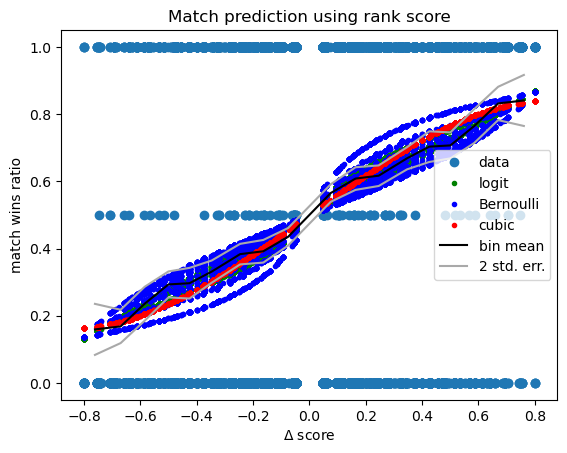

In [141]:
plot_data2(data, mode='linear')
plt.title(f"Match prediction using rank score")
plt.show()

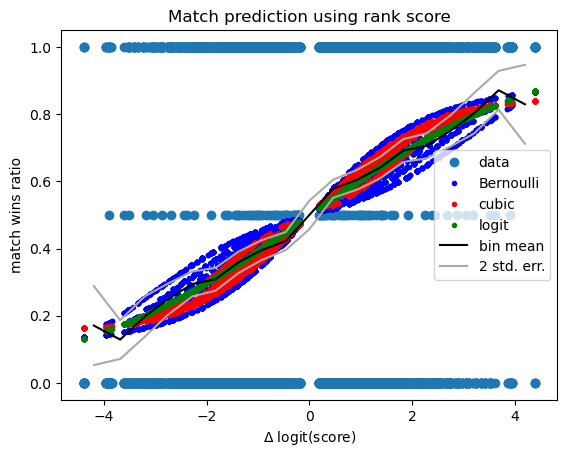

In [142]:
plot_data2(data, mode='logit')
plt.title(f"Match prediction using rank score")
plt.show()

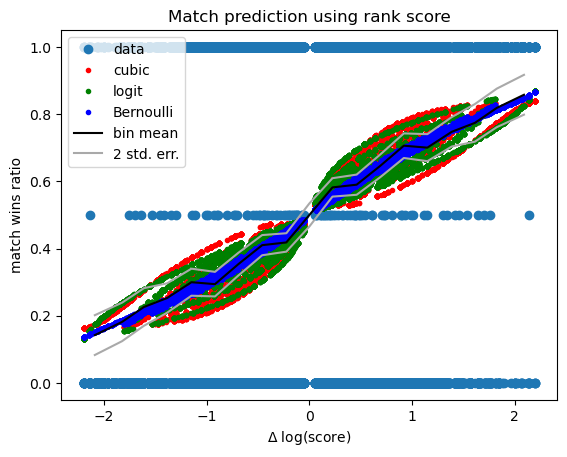

In [143]:
plot_data2(data, mode='log')
plt.title(f"Match prediction using rank score")
plt.show()

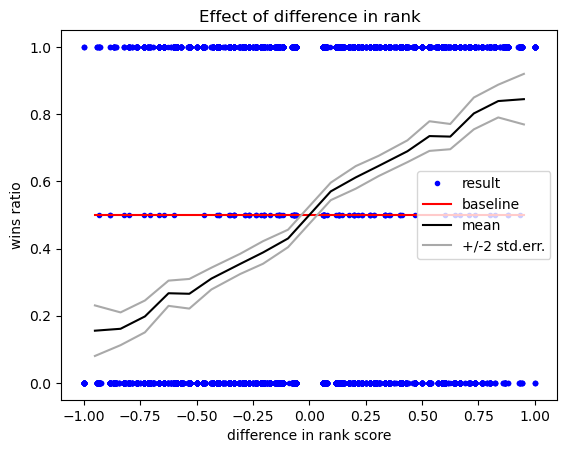

In [85]:
data, stats = weighted_plot(X, Y, num_samples)
plt.xlabel('difference in rank score')
plt.ylabel('wins ratio')
plt.title('Effect of difference in rank')
plt.show()

Observe that the higher the difference in ranks between the two opposing teams, the more likely the higher ranked team is to win.

### Regression models

Our standard model is Bernoulli regression in the standard form $p_A=\sigma(\beta\,x_A)$, where $x_A$ is the difference
in rank scores from team A's perspective.
However, we shall take the opportunity here to examine a few alternative models.
For instance, we note that $x_A\in[-1,1]$. Hence, we may suppose that $x_A=\tanh\kappa y_A$, for new feature 
$y_A\in(-\infty,+\infty)$, where $0<\kappa<1$ is some fixed constant chosen to retain finite values at the extremes of $x_A$.
The corresponding model is then defined as $p'_A\doteq\sigma(\beta\,y_A)$.

Alternatively, we note that $p_A\in[0,1]$, and hence we may define $p''_A\doteq 2p_A-1\in[-1,1]$. This motivates us to 
directly fit a polynomial model such as the cubic
$p''_A=\beta_1\,x_A+\beta_3\,x_A^3$. Note that the regression function must be odd, since if $x_A$ predicts $p_A$
then $-x_A$ must predict $1-p_A$. This follows from the constraint that swapping team A for team B in a two-team model should predict the probability of a win for team B and a loss for team A.

Finally, the fact that $x_A\in[-1,1]$ also motivates other models with odd regression functions, such as
$p'''_A\doteq\sin\beta\,x_A$.
We shall fit all of these above models for comparison.

In [86]:
n_points, x_means, y_means, y_se = stats
x_values = np.linspace(min(x_means), max(x_means), 100)

In [87]:
# Bernoulli regression
phi = np.array([1.0])
bd = BernoulliRegression(phi)
Z = no_intercept(X)
W = num_samples
print('Fit:', bd.fit(Y, Z, W))
print('Params:', bd.regression_parameters())
z_values = no_intercept(x_values)
y_preds = bd.distribution(z_values).mean()

Fit: (-0.624930335437228, 3, 1.901688140293345e-08)
Params: [1.87474355]


In [88]:
# logistic atanh regression
kappa = 0.9
phi = np.array([0.1])
bd2 = BernoulliRegression(phi)
Z = no_intercept(np.arctanh(kappa * X))
print('Fit:', bd2.fit(Y, Z, W))
print('Params:', bd2.regression_parameters())
z_values = no_intercept(np.arctanh(kappa * x_values))
y_preds2 = bd2.distribution(z_values).mean()

Fit: (-0.6258352861149801, 4, 6.507905325747743e-12)
Params: [1.80227024]


In [89]:
from sklearn.linear_model import LinearRegression

In [90]:
# cubic polynomial regression
Z = no_intercept(x_means, x_means**2, x_means**3)
lm = LinearRegression().fit(Z, y_means, n_points)
print(lm.intercept_, lm.coef_)
z_values = no_intercept(x_values, x_values**2, x_values**3)
y_preds3 = lm.predict(z_values)

0.5000000000000001 [ 4.78918293e-01 -2.77555756e-17 -1.41774460e-01]


In [91]:
# sine regression
alt_Y = np.arcsin(2 * y_means - 1)
lm2 = LinearRegression(fit_intercept=False).fit(x_means.reshape(-1, 1), alt_Y, n_points)
print(lm2.coef_)
y_preds4 = 0.5 * np.sin(lm2.predict(x_values.reshape(-1, 1))) + 0.5

[0.88338252]


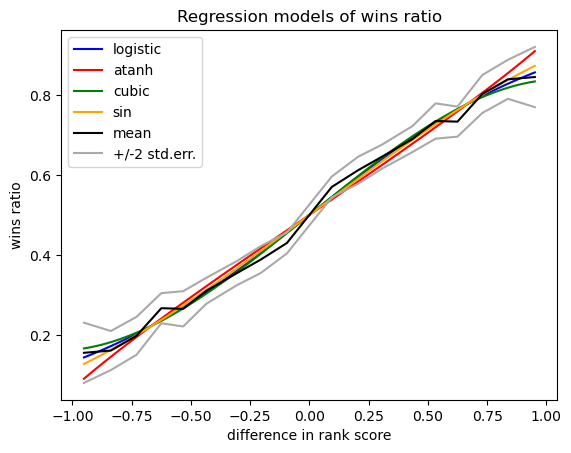

In [92]:
plt.plot(x_values, y_preds, 'b')
plt.plot(x_values, y_preds2, 'r')
plt.plot(x_values, y_preds3, 'g')
plt.plot(x_values, y_preds4, 'orange')
plt.plot(x_means, y_means, 'k')
plt.plot(x_means, 2 * y_se + y_means, 'darkgrey')
plt.plot(x_means, -2 * y_se + y_means, 'darkgrey')
plt.xlabel('difference in rank score')
plt.ylabel('wins ratio')
plt.title('Regression models of wins ratio')
plt.legend(['logistic', 'atanh', 'cubic', 'sin', 'mean', '+/-2 std.err.'])
plt.show()

Observe that all of the alternative models effectively perform the same, except for variations at the extremes.
Also note that none of the models correctly fit the empirically observed slope at $x_A=0$.

## Seasonal priors

Our current paradigm is to model matches within each season, and to adjust the team features from season to season.
In particular, we have assumed for convenience that no prior information is available for the first match for each team in any given season. However, if the team played in the previous season then we do in fact have the end-of-season results from that past season.

Therefore, we now examine whether a team's performance in the previous season is useful in helping to predict the outcome of their first match in the current season.

### Evidence of an effect

We shall use the end-of-season points ratio as the measure of past effectiveness of each team.

In [93]:
def get_seasonal_features(match, is_for):
    team = match_tools.get_match_team(match, is_for)
    ind = (df_seasonal.team == team) & (df_seasonal.season == match.season - 1)
    res = df_seasonal[ind]
    if len(res) == 0:
        return None
    return next(res.itertuples())

In [100]:
X = []
Y = []

df_minor = df_matches[df_matches['round'].str.startswith('R')]
for match in df_minor.itertuples():
    for is_for in [False, True]:
        features = match_tools.get_match_features(df_within, match, is_for)
        if features is not None:
            # Not the first match
            continue
        features = get_seasonal_features(match, is_for)
        if features is None:
            # No team data for previous season
            x = 0.5
        else:
            x = features.wins_ratio
        y = 0.5 * (1 + match_tools.get_match_result(match, is_for))
        X.append(x)
        Y.append(y)

Y = np.array(Y)
X = np.array(X)

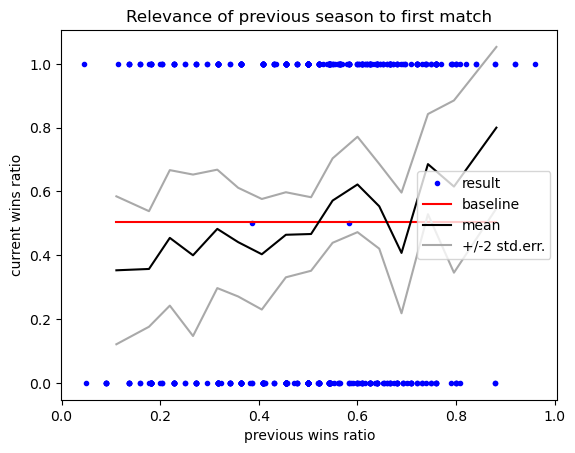

In [103]:
data, stats = weighted_plot(X, Y)
plt.xlabel('previous wins ratio')
plt.ylabel('current wins ratio')
plt.title('Relevance of previous season to first match')
plt.show()

In [123]:
df = pd.DataFrame(data=0, index=['positive', 'neutral', 'negative'], columns=[WIN, DRAW, LOSS])
df.loc['positive', 'win'] = sum((X > 0.5) & (Y > 0.5))
df.loc['positive', 'draw'] = sum((X > 0.5) & (Y == 0.5))
df.loc['positive', 'loss'] = sum((X > 0.5) & (Y < 0.5))
df.loc['neutral', 'win'] = sum((X == 0.5) & (Y > 0.5))
df.loc['neutral', 'draw'] = sum((X == 0.5) & (Y == 0.5))
df.loc['neutral', 'loss'] = sum((X == 0.5) & (Y < 0.5))
df.loc['negative', 'win'] = sum((X < 0.5) & (Y > 0.5))
df.loc['negative', 'draw'] = sum((X < 0.5) & (Y == 0.5))
df.loc['negative', 'loss'] = sum((X < 0.5) & (Y < 0.5))

In [124]:
df

,win,draw,loss
positive,149,1,109
neutral,25,0,29
negative,99,1,132


In [125]:
df.loc['positive'] += 0.5 * df.loc['neutral']
df.loc['negative'] += 0.5 * df.loc['neutral']
df.drop(index='neutral', inplace=True)
df['win'] += 0.5 * df['draw']
df['loss'] += 0.5 * df['draw']
df.drop(columns='draw', inplace=True)
df[RATIO] = df['win'] / (df['win'] + df['loss'])

In [126]:
df

,win,loss,wins_ratio
positive,162.0,124.0,0.566434
negative,112.0,147.0,0.432432


In [128]:
p = df.loc['positive', RATIO]
q = 1 - p
n = df.loc['positive', WIN] + df.loc['positive', LOSS]
se = np.sqrt(p * q / n)
print(f"Prob(loss|+ve) = {q}, Prob(win|+ve) = {p}")
print(f"mean +/- 2 std.err. = ({p - 2 * se}, {p + 2 * se})")

Prob(loss|+ve) = 0.43356643356643354, Prob(win|+ve) = 0.5664335664335665
mean +/- 2 std.err. = (0.507826592785777, 0.6250405400813559)
